In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost


In [2]:
import pandas as pd

In [4]:
train_list = pd.read_csv("Train_List.csv")
train_list.head()

,Train_Number,Train_Name,From_Station,To_Station,Type
0,13181,KAZIRANGA EXP,KOAA,GHY,Mail/Express
1,5640,KOAA SCL SPL,KOAA,GHY,Mail/Express
2,2501,KOAA AGTL SPL,KOAA,GHY,Mail/Express
3,2517,KOAA GHY SPL,KOAA,GHY,Superfast
4,22502,NTSK SMVB EXPRESS,GHY,PER,Superfast


In [5]:
df = pd.read_csv("02501.csv")  #  we can replace with any train file also.
df.head()

,Station,Station_Name,Average_Delay(min),Right Time (0-15 min's),Slight Delay (15-60 min's),Significant Delay (>1 Hour),Cancelled/Unknown
0,KOAA,KOLKATA,7,94.23,1.92,3.85,0.0
1,BDC,BANDEL JN,11,90.38,5.77,3.85,0.0
2,NDAE,NABADWIP DHAM,22,61.54,34.62,3.85,0.0
3,KWAE,KATWA,19,69.23,25.00,5.77,0.0
4,AZ,AZIMGANJ JN,14,86.54,7.69,5.77,0.0


In [6]:
import pandas as pd
# step 1:- we added a numerical station index.
df['Station_Index'] = df.index

In [7]:
df.head()

,Station,Station_Name,Average_Delay(min),Right Time (0-15 min's),Slight Delay (15-60 min's),Significant Delay (>1 Hour),Cancelled/Unknown,Station_Index
0,KOAA,KOLKATA,7,94.23,1.92,3.85,0.0,0
1,BDC,BANDEL JN,11,90.38,5.77,3.85,0.0,1
2,NDAE,NABADWIP DHAM,22,61.54,34.62,3.85,0.0,2
3,KWAE,KATWA,19,69.23,25.00,5.77,0.0,3
4,AZ,AZIMGANJ JN,14,86.54,7.69,5.77,0.0,4


In [8]:
#Step 2: Add previous delay column (for propagation modeling)
df['Prev_Delay'] = df['Average_Delay(min)'].shift(1).fillna(0)

In [9]:
# Step 3: Classify delay into 3 bins: Low, Medium, High
bins = [-1, 15, 60, float('inf')]
labels = ['Low', 'Medium', 'High']
df['Delay_Class'] = pd.cut(df['Average_Delay(min)'], bins=bins, labels=labels)

In [10]:
df.head()

,Station,Station_Name,Average_Delay(min),Right Time (0-15 min's),Slight Delay (15-60 min's),Significant Delay (>1 Hour),Cancelled/Unknown,Station_Index,Prev_Delay,Delay_Class
0,KOAA,KOLKATA,7,94.23,1.92,3.85,0.0,0,0.0,Low
1,BDC,BANDEL JN,11,90.38,5.77,3.85,0.0,1,7.0,Low
2,NDAE,NABADWIP DHAM,22,61.54,34.62,3.85,0.0,2,11.0,Medium
3,KWAE,KATWA,19,69.23,25.00,5.77,0.0,3,22.0,Medium
4,AZ,AZIMGANJ JN,14,86.54,7.69,5.77,0.0,4,19.0,Low


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features and target
X = df[['Station_Index', 'Prev_Delay']]
y = df['Delay_Class']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       1.00      1.00      1.00         4
         Low       0.00      0.00      0.00         2
      Medium       0.00      0.00      0.00         1

    accuracy                           0.57         7
   macro avg       0.33      0.33      0.33         7
weighted avg       0.57      0.57      0.57         7



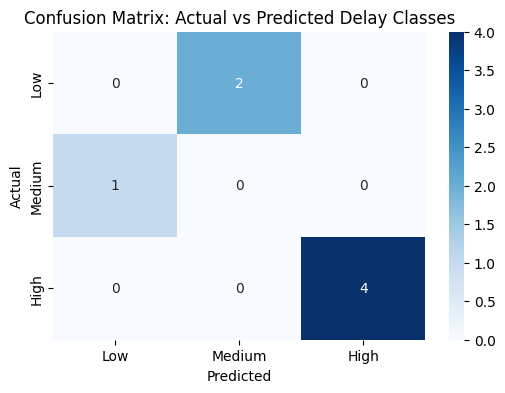

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Actual vs Predicted Delay Classes')
plt.show()


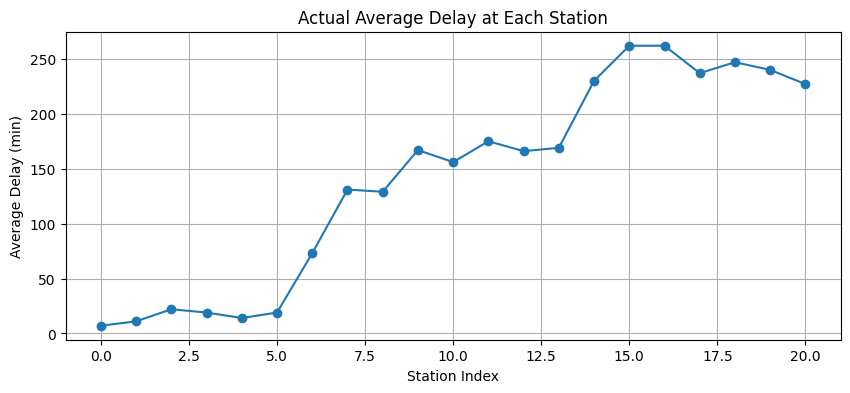

In [13]:
# Plot actual delay by station index
plt.figure(figsize=(10, 4))
plt.plot(df['Station_Index'], df['Average_Delay(min)'], marker='o')
plt.title('Actual Average Delay at Each Station')
plt.xlabel('Station Index')
plt.ylabel('Average Delay (min)')
plt.grid(True)
plt.show()


In [14]:
# Add predicted class column to test data for comparison
test_results = X_test.copy()
test_results['Actual'] = y_test
test_results['Predicted'] = y_pred

print(test_results)


    Station_Index  Prev_Delay  Actual Predicted
0               0         0.0     Low    Medium
17             17       262.0    High      High
15             15       230.0    High      High
1               1         7.0     Low    Medium
8               8       131.0    High      High
5               5        14.0  Medium       Low
11             11       156.0    High      High


In [15]:
# Add more features from the CSV
df['Right_Pct'] = df["Right Time (0-15 min's)"]
df['Slight_Pct'] = df["Slight Delay (15-60 min's)"]
df['High_Pct'] = df["Significant Delay (>1 Hour)"]

# New feature set
X = df[['Station_Index', 'Prev_Delay', 'Right_Pct', 'Slight_Pct', 'High_Pct']]
y = df['Delay_Class']


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model with class weight balancing
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       1.00      1.00      1.00         4
         Low       0.00      0.00      0.00         2
      Medium       0.33      1.00      0.50         1

    accuracy                           0.71         7
   macro avg       0.44      0.67      0.50         7
weighted avg       0.62      0.71      0.64         7



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
import pandas as pd

# Load the second train route
df2 = pd.read_csv('02502.csv')

# Add train ID column to distinguish later
df2['Train_ID'] = '02502'

# Add station index (i.e., order of station)
df2['Station_Index'] = df2.index

# Add previous station delay as a feature
df2['Prev_Delay'] = df2['Average_Delay(min)'].shift(1).fillna(0)

# Create delay class
bins = [-1, 15, 60, float('inf')]
labels = ['Low', 'Medium', 'High']
df2['Delay_Class'] = pd.cut(df2['Average_Delay(min)'], bins=bins, labels=labels)

# Rename the columns to match first dataset if needed (just to be safe)
df2.columns = df2.columns.str.strip()


In [19]:
# Add Train_ID to first train if not already added
df['Train_ID'] = '02501'

# Combine both datasets
combined_df = pd.concat([df, df2], ignore_index=True)

In [20]:
# Convert Train_ID to numeric (ML needs numbers)
combined_df['Train_ID_Code'] = combined_df['Train_ID'].astype('category').cat.codes

# Select features
X = combined_df[['Train_ID_Code', 'Station_Index', 'Prev_Delay',
                 "Right Time (0-15 min's)", "Slight Delay (15-60 min's)", "Significant Delay (>1 Hour)"]]

# Target column
y = combined_df['Delay_Class']


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model with class balancing
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       1.00      1.00      1.00         9
         Low       1.00      1.00      1.00         1
      Medium       1.00      1.00      1.00         3

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



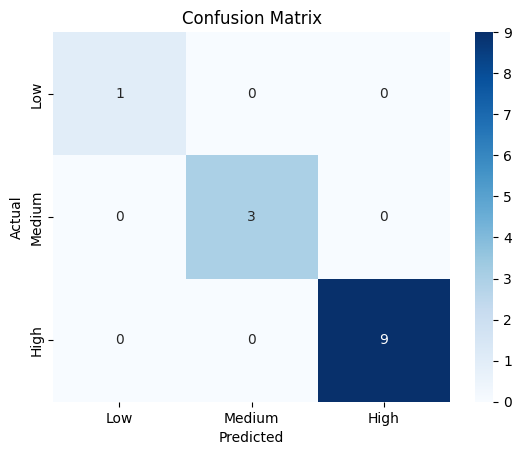

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [23]:
print(combined_df.shape)


(42, 15)


In [24]:
test_df = pd.read_csv('02517.csv')

# Preprocessing (same as training)
test_df['Train_ID'] = '02517'
test_df['Station_Index'] = test_df.index
test_df['Prev_Delay'] = test_df['Average_Delay(min)'].shift(1).fillna(0)

# You can optionally compute delay class for evaluation
bins = [-1, 15, 60, float('inf')]
labels = ['Low', 'Medium', 'High']
test_df['Delay_Class'] = pd.cut(test_df['Average_Delay(min)'], bins=bins, labels=labels)

# Convert Train_ID to numerical code (use same method as training)
test_df['Train_ID_Code'] = 2  # If 'Train_1' was 0, '02502' was 1, assign new ID here


In [25]:
X_new = test_df[['Train_ID_Code', 'Station_Index', 'Prev_Delay',
                 "Right Time (0-15 min's)", "Slight Delay (15-60 min's)", "Significant Delay (>1 Hour)"]]



In [26]:
y_pred_new = model.predict(X_new)

# Add predictions to the DataFrame
test_df['Predicted_Delay_Class'] = y_pred_new

# Optional: Compare with actual class if available
print(test_df[['Station', 'Delay_Class', 'Predicted_Delay_Class']])


   Station Delay_Class Predicted_Delay_Class
0     KOAA      Medium                   Low
1      BDC      Medium                Medium
2     NDAE      Medium                Medium
3     KWAE      Medium                Medium
4       AZ      Medium                Medium
5     JRLE      Medium                Medium
6     MLDT        High                  High
7      KNE        High                  High
8      NJP        High                  High
9      NCB        High                  High
10     NOQ        High                  High
11     KOJ        High                  High
12     NBQ        High                  High
13    GLPT        High                  High
14     GHY        High                  High


In [27]:
from sklearn.metrics import classification_report

# If 'Delay_Class' is available:
print(classification_report(test_df['Delay_Class'], test_df['Predicted_Delay_Class']))


              precision    recall  f1-score   support

        High       1.00      1.00      1.00         9
         Low       0.00      0.00      0.00         0
      Medium       1.00      0.83      0.91         6

    accuracy                           0.93        15
   macro avg       0.67      0.61      0.64        15
weighted avg       1.00      0.93      0.96        15



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ------------------------
# Step 1: Define loading function
# ------------------------
def load_and_prepare_route(filepath, train_id_code):
    df = pd.read_csv(filepath)
    df['Train_ID'] = filepath.split('.')[0]
    df['Train_ID_Code'] = train_id_code
    df['Station_Index'] = df.index
    df['Prev_Delay'] = df['Average_Delay(min)'].shift(1).fillna(0)

    # Delay classification
    bins = [-1, 15, 60, float('inf')]
    labels = ['Low', 'Medium', 'High']
    df['Delay_Class'] = pd.cut(df['Average_Delay(min)'], bins=bins, labels=labels)

    return df

# ------------------------
# Step 2: Load all train routes
# ------------------------

# First two already used
df1 = load_and_prepare_route('02501.csv', 0)      # Replace 'first_train.csv' with actual file
df2 = load_and_prepare_route('02502.csv', 1)

# Now the 5 new ones:
df3 = load_and_prepare_route('02518.csv', 2)
df4 = load_and_prepare_route('05639.csv', 3)
df5 = load_and_prepare_route('05640.csv', 4)
df6 = load_and_prepare_route('12346.csv', 5)
df7 = load_and_prepare_route('12423.csv', 6)

# ------------------------
# Step 3: Combine all
# ------------------------
combined_df = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

# ------------------------
# Step 4: Prepare features and labels
# ------------------------
X = combined_df[['Train_ID_Code', 'Station_Index', 'Prev_Delay',
                 "Right Time (0-15 min's)", "Slight Delay (15-60 min's)", "Significant Delay (>1 Hour)"]]

y = combined_df['Delay_Class']

# ------------------------
# Step 5: Train/Test split and model
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# ------------------------
# Step 6: Predict and evaluate
# ------------------------
y_pred = model.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# (Optional) Save combined data
combined_df.to_csv("combined_train_routes.csv", index=False)



📊 Classification Report:

              precision    recall  f1-score   support

        High       0.94      1.00      0.97        30
         Low       1.00      0.60      0.75         5
      Medium       0.82      0.82      0.82        11

    accuracy                           0.91        46
   macro avg       0.92      0.81      0.85        46
weighted avg       0.92      0.91      0.91        46



In [29]:
X_test['Actual'] = y_test
X_test['Predicted'] = y_pred
X_test.to_csv('final_model_predictions.csv', index=False)


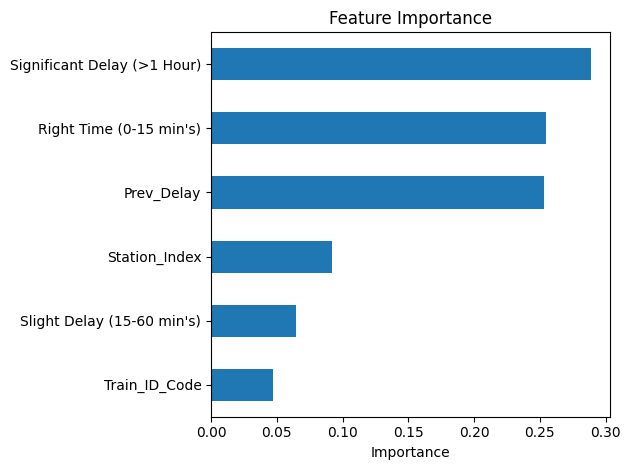

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [32]:
from google.colab import files
files.download('combined_train_routes.csv')
files.download('final_model_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
import pickle
pickle.dump(, open('trained_rf_model.pkl', 'wb'))

In [34]:
from google.colab import files
files.download('trained_rf_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>